### Identifying Backgrounds with a Convolutional Neural Network

In [79]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import random
from sklearn.metrics import accuracy_score, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

%matplotlib inline

In [65]:
def is_image(fn):
    '''
    Check if a filename 'fn' is an image file
    '''

    extensions = ['.jpg', '.jpeg', '.png']

    return any(fn.lower().endswith(ext) for ext in extensions)

def find_images_in_folder(folder_path, verbose=False):
    '''
    Get all the valid images in folder 'folder_path'
    '''

    full_image_paths = []

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        if os.path.isfile(file_path) and is_image(filename):
            try:
                _ = Image.open(file_path)
                full_image_paths.append(file_path)

                if verbose:
                    print(f"Read image: {file_path}")
            except Exception as e:
                print(f"Error failed to read {filename}: {e}")

    return full_image_paths

In [75]:
'''
Encapsulate image data into a 'Dataset' class

The mean and standard deviation for the RGB values are
empirically derived from the ImageNet dataset

Image data axes is as follows: (color chanel, height, width)
'''

class HW4_Dataset(Dataset):
    def __init__(self, path, class_names, new_size=None, verbose=False):
        self.full_image_paths = []
        self.class_names = class_names
        self.gt_class_idx = []

        '''
        Label images with their corresponding class index
        '''

        for idx, label in enumerate(class_names):
            folder_path = os.path.join(path, label)
            image_paths = find_images_in_folder(folder_path, verbose)
            self.full_image_paths += image_paths
            self.gt_class_idx += [idx] * len(image_paths)

        if new_size is not None:
            self.transform = transforms.Compose([
                transforms.Resize(new_size),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

    def __len__(self):
        return len(self.full_image_paths)

    def __getitem__(self, idx):
        '''
        Get image and corresponding label at index 'idx'
        '''

        fp = self.full_image_paths[idx]
        class_i = self.gt_class_idx[idx]
        im = Image.open(fp)
        im = self.transform(im)

        return im, class_i

class_names = ['grass', 'ocean', 'redcarpet', 'road', 'wheatfield']

'''
Reduce the original 240x360 images to 60x90

Setting it to None or 240 leaves the images unchanged
'''

new_size = 60
verbose = False

train_dataset = HW4_Dataset('data/train', class_names, new_size=new_size, verbose=verbose)
valid_dataset = HW4_Dataset('data/valid', class_names, new_size=new_size, verbose=verbose)
test_dataset = HW4_Dataset('data/test', class_names, new_size=new_size, verbose=verbose)

The validation dataset has 750 images
After the shuffle the 0th image has class index 0 (grass)
Image shape is (240, 360, 3)


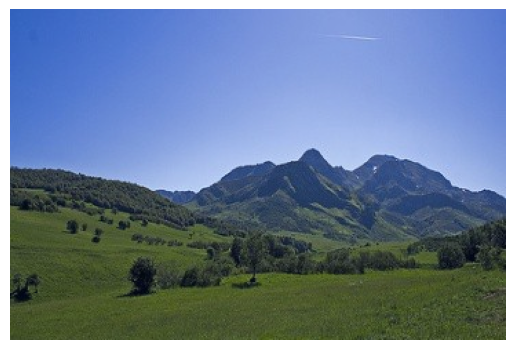

In [71]:
'''
Look at a random image
'''

n = len(valid_dataset)
print(f'The validation dataset has {n} images')

indices = list(range(n))
random.shuffle(indices)

im, class_idx = valid_dataset[indices[0]]
print(f'After the shuffle the 0th image has class index {class_idx} ({class_names[class_idx]})')

im_np = im.numpy().transpose((1, 2, 0))
print(f'Image shape is {im_np.shape}')

im_min = im_np.min()
im_max = im_np.max()
im_np = (im_np - im_min) / (im_max - im_min)

plt.imshow(im_np)
plt.axis('off')
plt.show()

5 random images:


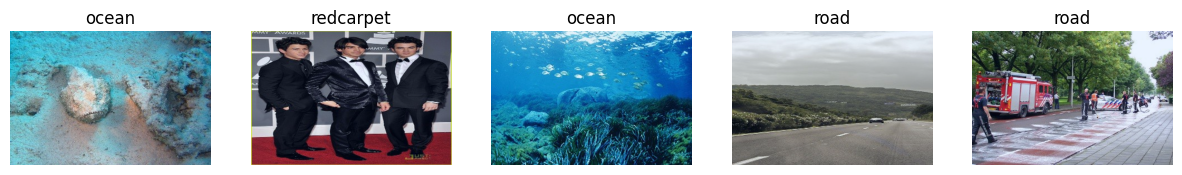


Within the training set: 700 pictures have a grass background,
                         700 pictures have a ocean background,
                         700 pictures have a redcarpet background,
                         700 pictures have a road background, and 
                         700 pictures have a wheatfield background

Within the validation set: 150 pictures have a grass background,
                           150 pictures have a ocean background,
                           150 pictures have a redcarpet background,
                           150 pictures have a road background, and 
                           150 pictures have a wheatfield background

Within the testing set: 150 pictures had a grass background,
                        150 pictures have a ocean background,
                        150 pictures have a redcarpet background,
                        150 pictures have a road background, and 
                        150 pictures have a wheatfield background

All three s

In [73]:
'''
Display a random selection of images with their corresponding
labels

Then show how many images from the training and testing set
belong to each label
'''

all_images, all_labels = [], []
x, y, z = len(train_dataset), len(valid_dataset), len(test_dataset)

for i in range(x + y + z):
    if i < x:
        im, label = train_dataset[i]
    elif i < x + y:
        im, label = valid_dataset[i - x]
    else:
        im, label = test_dataset[i - x - y]

    im = im.numpy().transpose((1, 2, 0))
    im = (im - im.min()) / (im.max() - im.min())

    all_images.append(im)
    all_labels.append(label)

random_images, random_labels = [], []

for _ in range(5):
    random_index = np.random.randint(0, x + y + z)
    random_images.append(all_images[random_index])
    random_labels.append(all_labels[random_index])

print('5 random images:')

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axes[i].imshow(random_images[i])
    axes[i].set_title(class_names[random_labels[i]])
    axes[i].axis('off')

plt.show()

print()

label_count_train = np.bincount(all_labels[:x])
label_count_valid = np.bincount(all_labels[x:x + y])
label_count_test = np.bincount(all_labels[x + y:x + y + z])

print(f'''Within the training set: {label_count_train[0]} pictures have a grass background,
                         {label_count_train[1]} pictures have a ocean background,
                         {label_count_train[2]} pictures have a redcarpet background,
                         {label_count_train[3]} pictures have a road background, and 
                         {label_count_train[4]} pictures have a wheatfield background\n''')

print(f'''Within the validation set: {label_count_valid[0]} pictures have a grass background,
                           {label_count_valid[1]} pictures have a ocean background,
                           {label_count_valid[2]} pictures have a redcarpet background,
                           {label_count_valid[3]} pictures have a road background, and 
                           {label_count_valid[4]} pictures have a wheatfield background\n''')

print(f'''Within the testing set: {label_count_test[0]} pictures had a grass background,
                        {label_count_test[1]} pictures have a ocean background,
                        {label_count_test[2]} pictures have a redcarpet background,
                        {label_count_test[3]} pictures have a road background, and 
                        {label_count_test[4]} pictures have a wheatfield background\n''')

print('All three sets have uniform frequency for each background: 0.2')

In [78]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
  
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.fc1 = nn.Linear(32 * 15 * 22, 128)
        self.fc2 = nn.Linear(128, 5)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
  
        x = x.view(-1, 32 * 15 * 22)
    
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
    
        return x

model = CNN()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

'''
Maximum 10 epochs for good generalization

Patience is the maximum number of non
increasing accuracies allowed in a row
'''

epochs = 10
best_accuracy = 0.0
patience = 3
counter = 0

for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(images)
        
        loss = loss_fn(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total

    print(f'Epoch {epoch + 1}, Training Loss: {(running_loss / len(train_loader)):.4f}, Validation Accuracy: {accuracy:.4f}')

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        counter = 0

        torch.save(model.state_dict(), 'best_model.pth')
        print("Best model saved.")
    else:
        counter += 1
        if counter >= patience:
            print('Validation accuracy did not improve. Stopping training.')
            break

Epoch 1, Training Loss: 0.8330, Validation Accuracy: 0.8053
Best model saved.
Epoch 2, Training Loss: 0.4816, Validation Accuracy: 0.8053
Epoch 3, Training Loss: 0.4235, Validation Accuracy: 0.8307
Best model saved.
Epoch 4, Training Loss: 0.3281, Validation Accuracy: 0.8213
Epoch 5, Training Loss: 0.2493, Validation Accuracy: 0.8053
Epoch 6, Training Loss: 0.1898, Validation Accuracy: 0.8373
Best model saved.
Epoch 7, Training Loss: 0.1502, Validation Accuracy: 0.8267
Epoch 8, Training Loss: 0.0968, Validation Accuracy: 0.8293
Epoch 9, Training Loss: 0.0648, Validation Accuracy: 0.8240
Validation accuracy did not improve. Stopping training.


In [86]:
model = CNN()
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

all_predictions = []
all_targets = []

with torch.no_grad():
    for images, labels in test_loader:
        logits = model(images)

        probabilities = torch.softmax(logits, dim=1)

        _, predicted = torch.max(probabilities, 1)

        all_predictions.extend(predicted.tolist())
        all_targets.extend(labels.tolist())

all_predictions = torch.tensor(all_predictions)
all_targets = torch.tensor(all_targets)

accuracy = torch.sum(all_predictions == all_targets).item() / len(all_targets)
print(f"Test Accuracy: {accuracy:.4f}\n")

all_predictions_np = all_predictions.numpy()
all_targets_np = all_targets.numpy()

accuracy_per_class = []
for i in range(5):
    indices = all_targets_np == i
    class_accuracy = accuracy_score(all_targets_np[indices], all_predictions_np[indices])
    accuracy_per_class.append(class_accuracy)

print("Accuracy per class:\n")
for i, acc in enumerate(accuracy_per_class):
    print(f"Class {i} ({class_names[i]}): {acc:.4f}")

print()

conf_matrix = confusion_matrix(all_targets_np, all_predictions_np)

print("Confusion Matrix:")
print(conf_matrix)

Test Accuracy: 0.8373

Accuracy per class:

Class 0 (grass): 0.8600
Class 1 (ocean): 0.7867
Class 2 (redcarpet): 0.9600
Class 3 (road): 0.8133
Class 4 (wheatfield): 0.7667

Confusion Matrix:
[[129   6   1   6   8]
 [  9 118   2  13   8]
 [  1   0 144   4   1]
 [ 10   8   5 122   5]
 [ 20   2   7   6 115]]


The classifier works best with picking out the red carpet, but most poorly when given a wheat feild.